# Results correlation analysis

In [45]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scripts.utils as utils
plot_kwargs = {'bbox_inches': "tight", 'dpi': 200}


plt.rcParams['font.family'] = 'monospace'

config = utils.load_config("scripts")
tempdir = config['paths']['tempdir']
indir = config['paths']['resultsdir']
outdir = config['paths']['resultsdir']
figdir = config['paths']['figdir']


RZ_IDS = [*gpd.read_file(os.path.join(tempdir, "wrz_buffer.gpkg"))['RZ_ID'].unique()]
INDICATOR = "ep"
SCENARIOS = ["BS", "NF", "FF"]
INDICATORS = ['ep_total', 'ep_mean', 'mean_anomaly_total',
              'q50_anomaly_total', 'mean_deficit_total', 'q50_deficit_total',
              'q75_deficit_total', 'q90_deficit_total']
INDICATOR_LABELS = {'ep_total': 'Total effective precipitation',
                    'ep_mean': 'Mean effective precipitation',
                    'mean_anomaly_total': 'Average effective precipitation anomaly',
                    'q50_anomaly_total': 'Median effective precipitation anomaly',
                    'mean_deficit_total': 'Average effective precipitation deficit',
                    'q50_deficit_total': 'Median effective precipitation deficit',
                    'q75_deficit_total': 'Q75 effective precipitation deficit',
                    'q90_deficit_total': 'Q90 effective precipitation deficit',
                    'severity': 'severity'
                   }

# Compare to David's NF results

# Get all correlations

In [47]:
# get correlations for every variable with the LoS severity and save to dataframe
for RZ_ID in RZ_IDS:
    dfs = []
    for scenario in SCENARIOS:
        datadir = os.path.join(indir, scenario.lower(), "events")
        datapath = os.path.join(datadir, f"wrz_{RZ_ID}.csv")
        if os.path.exists(datapath):
            dfs.append(pd.read_csv(datapath))
    if len(dfs) > 0:
        df_wrz = pd.concat(dfs) # concatenate all W@H scenarios

        corr_dfs = []
        for indicator in INDICATORS:
            corrs = {}
            pvals = {}
            for buffer in df_wrz['buffer'].unique():
                df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
                buffer = int(buffer)
                for backcast in df_wrz['backcast'].unique():
                    df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
                    corr, pval = spearmanr(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['severity'])
                    corrs[(buffer, backcast)] = [corr]
                    pvals[(buffer, backcast)] = [pval]

            corrs_df = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: f'{indicator}_r'})
            pvals_df = pd.DataFrame(pvals).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: f'{indicator}_p'})
            corrs_df[f'{indicator}_p'] = pvals_df[f'{indicator}_p']
            corrs_df = corrs_df.set_index(['buffer', 'backcast'])
            corr_dfs.append(corrs_df)

        corrs_df = pd.concat(corr_dfs, axis=1).reset_index()
        corrs_df.to_csv(os.path.join(outdir, 'correlations', f'wrz_{RZ_ID}.csv'), index=False)
    else:
        print(f"No dataframes found for WRZ {RZ_ID}")

No dataframes found for WRZ 69
No dataframes found for WRZ 91
No dataframes found for WRZ 101


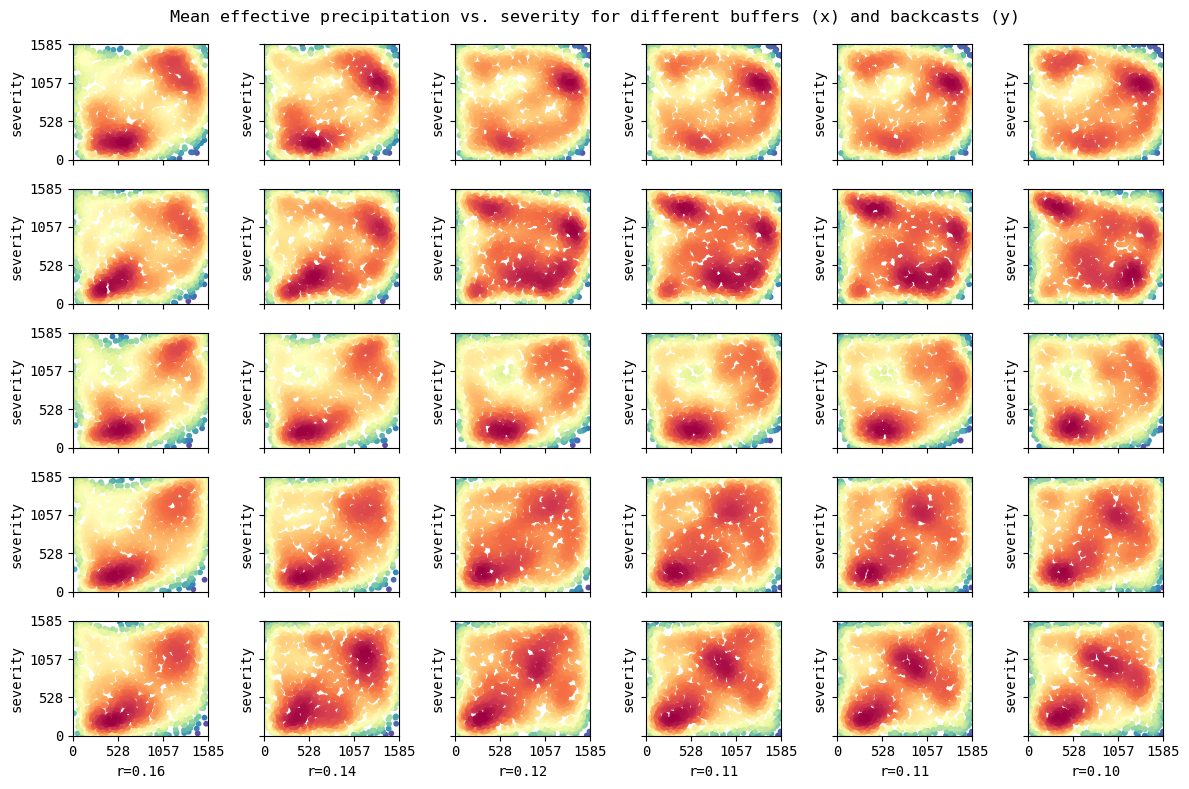

In [50]:
# create rank scatter plots for different buffer sizes/backcasts for each WRZ
from scipy.stats import gaussian_kde

def rank(x):
    if x.std() == 0:
        ranked = np.array([len(x) / 2 + 0.5] * len(x))
    else:
        temp = x.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(x))
        ranked = ranks + 1
    return ranked


def scatter_density(x, y, ax, title='', cmap='cividis'):
    """Sometimes first doesn't work -- need to resolve why later."""
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, s=10, cmap=cmap)
    ax.set_title(title)
    return ax


all_df = pd.concat(dfs)
indicator = 'ep_mean'
backcasts = all_df['backcast'].unique()
buffers = all_df['buffer'].unique()
fig, axs = plt.subplots(len(backcasts), len(buffers), figsize=(12, 8), layout='tight')
for i, backcast in enumerate(backcasts):
    for j, buffer in enumerate(buffers):
        df_sub = all_df[all_df['buffer'] == buffer].copy()
        df_sub = df_sub[df_sub['backcast'] == backcast].copy()
        
        xmin, xmax = 0, len(df_sub)
        ymin, ymax = 0, len(df_sub)
        
        x = rank(df_sub[indicator])
        y = rank(df_sub['severity'])
        
        scatter_density(x, y, axs[i, j], cmap='Spectral_r')
        axs[i, j].set_xlabel(f"r={spearmanr(df_sub[indicator], df_sub['severity'])[0]:.2f}")
        axs[i, j].set_xlim([xmin, xmax])
        axs[i, j].set_ylim([ymin, ymax])
        axs[i, j].set_xticks(np.linspace(xmin, xmax, 4))
        axs[i, j].set_yticks(np.linspace(ymin, ymax, 4))
        axs[i, j].label_outer()
        axs[i, j].set_ylabel('severity')

fig.suptitle(f"{INDICATOR_LABELS[indicator]} vs. severity for different buffers (x) and backcasts (y)");
fig.savefig(os.path.join(figdir, 'correlations', f'scatterplot_{indicator}.png'), **plot_kwargs)

In [28]:
# create correlation heatmaps for different buffer sizes/backcasts for each WRZ
def plot_heatmap(RZ_ID, indicator, outdir, **heatmap_kwargs):
    corrs_df_wrz = pd.read_csv(os.path.join(outdir, 'correlations', f'wrz_{RZ_ID}.csv'))
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_r', index='buffer', columns='backcast').transpose()
    pvals_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_p', index='buffer', columns='backcast').transpose()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', **heatmap_kwargs)
    
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. Severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')
    
    fig.suptitle(f"WRZ {RZ_ID}")
    return fig


for RZ_ID in RZ_IDS:
    for indicator in INDICATORS:
        fig = plot_heatmap(1, indicator, outdir)
        if not os.path.exists(os.path.join(figdir, 'correlations', f"{RZ_ID}")):
            os.makedirs(os.path.join(figdir, 'correlations', f"{RZ_ID}"))
        fig.savefig(os.path.join(figdir, 'correlations', f"{RZ_ID}", f"{indicator}.png"), **plot_kwargs)
        plt.close()

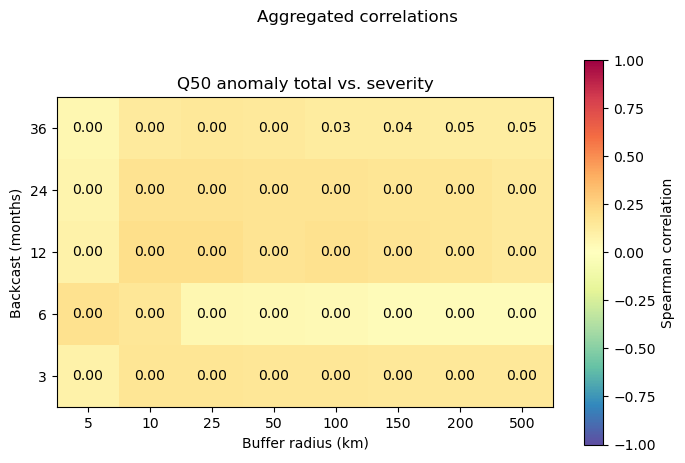

In [29]:
# create correlation heatmaps for different buffer sizes/backcasts over all WRZs
def plot_heatmap2(corrs_df_wrz, indicator):
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_r', index='buffer', columns='backcast').transpose()
    pvals_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_p', index='buffer', columns='backcast').transpose()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
    
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')
    
    fig.suptitle(f"Aggregated correlations")
    return fig


import glob
dfs = []
all_corr_csvs = glob.glob(os.path.join(outdir, 'correlations', f'wrz_*.csv'))

for csv in all_corr_csvs:
    dfs.append(pd.read_csv(csv))

    
all_corr_dfs = pd.concat(dfs, axis=0)

# get statistics
mean_corrs = all_corr_dfs.groupby(['buffer', 'backcast']).mean().reset_index()
median_corrs = all_corr_dfs.groupby(['buffer', 'backcast']).median().reset_index()


fig = plot_heatmap2(median_corrs, 'q50_anomaly_total')